In [1]:
%load_ext autoreload
%autoreload 2
%pdb
import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.DEBUG)

Automatic pdb calling has been turned ON


In [21]:
import sys
#sys.path.insert(0, '/home/ubuntu/Documents/infembed/infembed')
sys.path.insert(0, '/home/ubuntu/Documents/infembed/infembed')
sys.path.insert(0, '/home/ubuntu/Documents/infembed/data')
from data._core.spotcheck import get_spotcheck_dataloader, get_blindspots_df
sys.path.insert(0, '/home/ubuntu/Documents/infembed/models')
#sys.path.insert(0, '/home/ubuntu/Documents/infembed/')
# sys.path.insert(0, )
from infembed.embedder._core.fast_kfac_embedder import FastKFACEmbedder
import torchvision
from torch.utils.data import Subset, DataLoader, default_collate, Dataset
from torchvision.models import ResNet18_Weights, resnet18
import torch.nn as nn
from infembed.clusterer._core.sklearn_clusterer import SklearnClusterer
from infembed.clusterer._core.rule_clusterer import RuleClusterer
from sklearn.cluster import KMeans
from tqdm import tqdm
import pandas as pd
import torch
from typing import List
from infembed.utils.common import Data
from data._core.spotcheck import get_spotcheck_dataloader, get_blindspots_df
from models._core.spotcheck import get_spotcheck_model
from scripts.evaluate.helpers import is_in_blindspot_auc, get_metrics
import matplotlib.pyplot as plt

DEBUG:matplotlib:CACHEDIR=/home/ubuntu/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/ubuntu/.cache/matplotlib/fontlist-v330.json


### figure out device to compute embeddings on ###

In [3]:
cuda_device = 'cuda:0'
DEVICE = torch.device(cuda_device) if torch.cuda.is_available() else torch.device('cpu')
print('device:', DEVICE)

device: cuda:0


### define data
We will define the following:
- `eval_dataloader`: `DataLoader` for evaluation data.  This is used to compute embeddings for the evaluation data
- `eval_dataset`: `Dataset` for evaluation data.  This is used to retrieve individual examples for displaying.
- `train_dataloader`: `DataLoader` for training data.  This is needed to know how to compute embeddings for the evaluation data

In [13]:
TRIAL = 1

data_path = f"/spotcheck/error_clustering/experiments/Supplement/Datasets/Blindspots/Synthetic/complex-{TRIAL}"
train_dataloader = get_spotcheck_dataloader(
    path=data_path,
    phase='train',
    batch_size=32,
    device=cuda_device,
    positive_only=False,
    limit=5000,
    file_name_replace_prefix_from='/data/users/fultonwang/error_clustering',
    file_name_replace_prefix_to='/spotcheck/error_clustering',
)
eval_dataloader = get_spotcheck_dataloader(
    path=data_path,
    phase='test',
    batch_size=32,
    device=cuda_device,
    positive_only=False,
    limit=None,
    file_name_replace_prefix_from='/data/users/fultonwang/error_clustering',
    file_name_replace_prefix_to='/spotcheck/error_clustering',
)

### define model ###

In [6]:
model = get_spotcheck_model(
    checkpoint_path=f"/spotcheck/error_clustering/experiments/Supplement/Code/Synthetic/Outputs/complex-{TRIAL}/initial-tune/trial0/model.pt",
    device=DEVICE,
)

### define embedder ###

In [16]:
layers = [
    'fc',
#    'layer4.1.conv2',
]

embedder = FastKFACEmbedder(
    model=model,
    layers=layers,
    loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    sample_wise_grads_per_batch=True,
    projection_dim=100,
    projection_on_cpu=True,
    show_progress=True,
    per_layer_blocks=1,
)

### compute eigenvalues of hessian ###

In [20]:
_, _, eigvals = embedder._retrieve_projections_fast_kfac_embedder_helper(
    train_dataloader,
    True,
    True,
    None,
    None,
    True,
)

INFO:root:compute training data statistics
processing `hessian_dataset` batch:   0%|                                                                                                                                           | 0/157 [00:00<?, ?it/s]/home/ubuntu/miniconda3/envs/test2/lib/python3.9/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
processing `hessian_dataset` batch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:20<00:00,  7.59it/s]
INFO:root:compute factors for layer Linear(in_features=512, out_features=1, bias=True)


### display eigenvalues per layer per block

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/ubuntu/miniconda3/envs/test2/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/ubuntu/miniconda3/envs/test2/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/ubuntu/miniconda3/envs/test2/lib/pyt

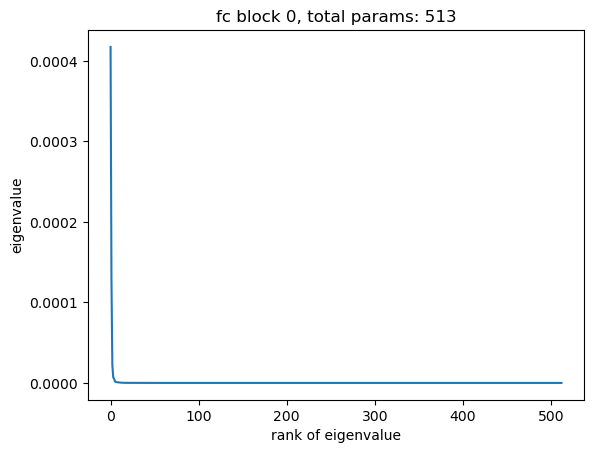

In [22]:
for (layer, layer_eigvals) in zip(layers, eigvals):
    for (k, layer_block_eigvals) in enumerate(layer_eigvals):
        num = 5000
        fig, ax = plt.subplots()
        _layer_block_eigvals = layer_block_eigvals[:num]
        ax.plot(list(range(len(_layer_block_eigvals))), _layer_block_eigvals)
        ax.set_xlabel('rank of eigenvalue')
        ax.set_ylabel('eigenvalue')
        ax.set_title(f"{layer} block {k}, total params: {len(layer_block_eigvals)}")
        fig.show()

### fit embedder ###

In [17]:
embedder.fit(train_dataloader)

INFO:root:compute factors, first pass to get eigenvalue threshold
INFO:root:compute training data statistics
processing `hessian_dataset` batch:   0%|                                                                                                                                           | 0/157 [00:00<?, ?it/s]

processing `hessian_dataset` batch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:19<00:00,  7.87it/s]
INFO:root:compute factors for layer Linear(in_features=512, out_features=1, bias=True)
INFO:root:compute factors, second pass to get eigenvalue threshold
INFO:root:compute training data statistics
processing `hessian_dataset` batch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:20<00:00,  7.57it/s]
INFO:root:compute factors for layer Linear(in_features=512, out_features=1, bias=True)


### compute embeddings for evaluation data ###
we then package them into a `Data` instance, which contains all kinds of data that could possibly be used to do the subsequent clustering, i.e. including tabular metadata as well.

In [18]:
embeddings = embedder.predict(eval_dataloader)
# data = Data(embeddings=embeddings)

Using FastKFACEmbedder to compute embeddings. Processing batch:   0%|          | 0/400 [00:00<?, ?it/s]

INFO:root:compute embeddings


### load embeddings ###

In [9]:
embeddings_path = "/home/ubuntu/Documents/infembed/infembed/examples/spotcheck/hydra_outputs/run_embeddings/spotcheck_several_embedders/0/embeddings.pt"
embeddings = torch.load(open(embeddings_path, 'rb'))
embeddings.shape

torch.Size([12800, 0])

### compute predictions for evaluation data ###

In [29]:
def _get_predictions_and_labels(_model, dataloader):
    dfs = []
    for batch in tqdm(dataloader):
        prediction_prob = (
            torch.nn.functional.softmax(_model(*batch[:-1]), dim=1)
            .detach()
            .to(device="cpu")
        )

        if prediction_prob.shape[1] == 1:
            prediction_prob = torch.cat([1.0 - prediction_prob, prediction_prob], dim=1)

        prediction_label = torch.argmax(prediction_prob, dim=1).to(device="cpu")
        label = batch[-1].to(
            device="cpu"
        )  # assuming batch is a tensor.  if not, can check
        dfs.append(
            pd.DataFrame(
                {
                    "prediction_label": prediction_label,
                    "label": label.squeeze(),
                    "prediction_prob": list(prediction_prob.numpy()),
                }
            )
        )
    df = pd.concat(dfs, axis=0)
    df.index = list(range(len(df)))
    return df


predictions_df = _get_predictions_and_labels(model, eval_dataloader)

  0%|                                                                                                                                                                               | 0/400 [00:00<?, ?it/s]

> /tmp/ipykernel_564115/2821096164.py(19)_get_predictions_and_labels()
     17         import pdb
     18         pdb.set_trace()
---> 19         dfs.append(
     20             pd.DataFrame(
     21                 {



  0%|▍                                                                                                                                                                      | 1/400 [00:00<06:37,  1.00it/s]

> /tmp/ipykernel_564115/2821096164.py(18)_get_predictions_and_labels()
     16         )  # assuming batch is a tensor.  if not, can check
     17         import pdb
---> 18         pdb.set_trace()
     19         dfs.append(
     20             pd.DataFrame(



  0%|▊                                                                                                                                                                      | 2/400 [00:02<06:58,  1.05s/it]

> /tmp/ipykernel_564115/2821096164.py(19)_get_predictions_and_labels()
     17         import pdb
     18         pdb.set_trace()
---> 19         dfs.append(
     20             pd.DataFrame(
     21                 {



  0%|▊                                                                                                                                                                      | 2/400 [00:03<10:32,  1.59s/it]


### can also load predictions ###

In [ ]:
pass

### read ground-truth blindspots ###

In [ ]:
blindspot_path = f"/spotcheck/error_clustering/experiments/Supplement/Datasets/Blindspots/Synthetic/complex-{TRIAL}/test/images.json"
blindspots_df = get_blindspots_df(blindspot_path)

### create metadata df ###

In [ ]:
metadata = pd.concat([predictions_df, blindspots_df], axis=1)

### create overall data structure ###

In [ ]:
data = Data(embeddings=embeddings, metadata=metadata)

### define clusterer ###

In [9]:
clusterer = SklearnClusterer(sklearn_clusterer=KMeans(n_clusters=25))

### do the clustering ###

In [13]:
clusters = clusterer.fit_predict(data)

### define ways to display clusters ###
these will all be functions whose input is a list of list of indices in the evaluation dataset

In [15]:
from infembed.visualization._core.common import PerClusterDisplayer, DisplayAccuracy

displayers = [
    PerClusterDisplayer([
        DisplayAccuracy(prediction_col='prediction_label', label_col='label')
    ])
]

### display the clusters ###

In [16]:
for displayer in displayers:
    displayer(clusters, data)

cluster #0
accuracy: 0.18 (55/307)
cluster #1
accuracy: 0.27 (7/26)
cluster #2
accuracy: 0.84 (3710/4426)
cluster #3
accuracy: 0.16 (6/37)
cluster #4
accuracy: 0.33 (13/39)
cluster #5
accuracy: 0.20 (13/66)
cluster #6
accuracy: 0.27 (11/41)
cluster #7
accuracy: 0.00 (0/1)
cluster #8
accuracy: 0.10 (3/29)
cluster #9
accuracy: 0.32 (9/28)


### compute metrics ###

In [ ]:
is_in_blindspot_auc(
    data.metadata,
    {
        'auc': is_in_blindspot_auc,
    },
)

### define rule clusterer ###

In [42]:
def _accuracy(data):
    return (data.metadata["prediction_label"] == data.metadata["label"]).mean()


def _size(data):
    return len(data)


rule_clusterer = RuleClusterer(
    clusterer_getter=lambda n_clusters: SklearnClusterer(KMeans(n_clusters=n_clusters)),
    cluster_rule=lambda data: _accuracy(data) < 0.2,
    stopping_rule=lambda data: _size(data) < 50,
    max_depth=5,
    branching_factor=2,
)

### do the rule clustering ###

In [43]:
rule_clusters = rule_clusterer.fit_predict(data)

### display the rule clusters

In [40]:
for displayer in displayers:
    displayer(rule_clusters, data)

cluster #0
accuracy: 0.18 (60/328)
